In [1]:
import gym
from gym import wrappers, logger
import numpy as np

# page 199 sutton and barto 2018
# http://incompleteideas.net/tiles/tiles3.html
from sutton_tile_coding import *
iht = IHT(32768)

def get_feature_vector(position, velocity, action):
    """
    page 199 sutton and barto 2018
    http://incompleteideas.net/tiles/tiles3.html
    """
    indices = tiles(iht, 8, [8*position/(0.5+1.2), 8*velocity/(0.07+0.07)], action)
    feature_vector = np.zeros((32768,))
    feature_vector[indices] = 1
    return feature_vector

In [2]:
assert np.array_equal(get_feature_vector(0.1, 0.1, [0]), 
                      get_feature_vector(0.1, 0.1, [1])) == False
assert np.array_equal(get_feature_vector(0.1, 0.1, [2]), 
                      get_feature_vector(0.1, 0.1, [2])) == True

In [3]:
class Agent(object):
    """
    page 199 sutton and barto 2018
    http://incompleteideas.net/tiles/tiles3.html
    """
    def __init__(self, 
                 param_vector_size, 
                 learning_rate, 
                 epsilon,
                 discount):
        self.weights = np.zeros((param_vector_size,))
        self.action_space = [0, 1, 2]
        self.learning_rate = learning_rate
        self.discount = discount
        self.feature_vector = get_feature_vector(0.0, 0.0, [0])
        self.action = [1]
        self.epsilon = epsilon
        
    def step(self, reward, new_state, done):
        if done:
            self.update_weights(reward, done)
        else:
            new_action = self.epsilon_greedy(new_state)
            new_feature_vector = get_feature_vector(new_state[0], 
                                                    new_state[1], 
                                                    new_action)
            self.update_weights(reward, done, new_feature_vector)
            self.feature_vector = new_feature_vector
            self.action = new_action
        return self.action
        
    def epsilon_greedy(self, new_state):
        import random
        
        random_float = random.uniform(0,1.0)
        if random_float > (1 - self.epsilon):
            action = [random.choice([0,1,2])]
        else:
            values = []
            for action_candidate in self.action_space:
                new_feature_vector = get_feature_vector(new_state[0], 
                                                        new_state[1], 
                                                        [action_candidate])
                values.append(self.compute_value(new_feature_vector))
            # https://stackoverflow.com/questions/16945518/
            #finding-the-index-of-the-value-which-is-the-min-or-
            #max-in-python
            action = [values.index(max(values))]
        return action
        
    def compute_value(self, feature_vector):
        return np.dot(self.weights, feature_vector)
    
    def update_weights(self, 
                       reward, 
                       terminal, 
                       feature_vector_tp1=np.zeros((32768,))): # placeholder
        if terminal:
            error = reward - self.compute_value(self.feature_vector)
        else:
            error = reward + self.discount * self.compute_value(feature_vector_tp1)- self.compute_value(self.feature_vector)
        self.weights += self.learning_rate * error * self.feature_vector

In [4]:
def train(agent, num_episodes=9000):
    env = gym.make("MountainCar-v0")
    episode_rewards = []
    action = [0]
    
    for episode in range(num_episodes):
        ob = env.reset()
        episode_rewards_sum = 0
        done = False
        count = 0
    
        while count < 1000:
            count += 1
            if count == 1000:
                done = True
            else:
                done = False
            new_ob, reward, done_env, _ = env.step(action[0])
            #env.render()
            if new_ob[0] >= 0.5:
                count = 1000
            episode_rewards_sum += reward
            action = agent.step(reward, new_ob, done)
        
        episode_rewards.append(episode_rewards_sum)
        
    return episode_rewards, agent

In [5]:
agent = Agent(param_vector_size=32768,
              learning_rate=(0.5/8),
              discount=0.9,
              epsilon=0.0)

In [6]:
episode_rewards, agent = train(agent, num_episodes=100)

Text(0.5, 1.0, 'SARSA on Mountain Car from Sutton and Barto with Tile Coding')

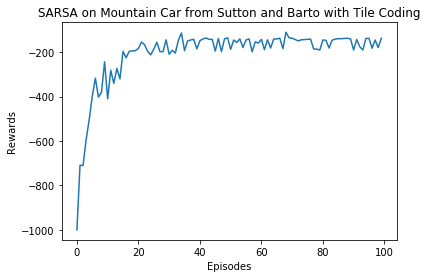

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(episode_rewards)
plt.ylabel("Rewards")
plt.xlabel("Episodes")
plt.title("SARSA on Mountain Car from Sutton and Barto with Tile Coding")